In [494]:
import numpy as np
import pandas as pd
import os
import re
from itertools import combinations
from datetime import datetime
import time
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

<span style="font-size: larger;">Primary/Composite fields: [trip_creation_time, route_schedule_uuid, trip_uuid, source_center, destination_center, cutoff_timestamp]</span>

<span style="font-size: 14px;">Assuming Distances are in Kms and Time in Mins<br>Training Data focuses on deliveries in September month, 2018<br>Missing values observed in Source Name and Destination Name fields</span>

In [495]:
data=pd.read_csv('delhivery_data.csv')
training_data=data.loc[data['data']=='training'].copy()
test_data=data.loc[data['data']=='test'].copy()

<span style="font-size: 14px;">Convert Fields to their appropriate data types</span>

In [496]:
datetime_columns=['trip_creation_time','od_start_time','od_end_time','cutoff_timestamp']
numeric_columns=['start_scan_to_end_scan','cutoff_factor','is_cutoff'
                ,'actual_distance_to_destination','actual_time','osrm_time'
                ,'osrm_distance','factor','segment_actual_time','segment_osrm_time'
                ,'segment_osrm_distance','segment_factor']
str_columns=['source_center','source_name','destination_center','destination_name'
            ,'trip_uuid','route_schedule_uuid','route_type']

def data_types(d,datetime_columns,numeric_columns,str_columns):
    #datetime_columns=[]
    for col in datetime_columns:
        d[col]=pd.to_datetime(d.loc[:,col],errors='coerce')
        
    for col in numeric_columns:
        d[col]=pd.to_numeric(d.loc[:,col],errors='coerce')
        
    for col in str_columns:
        d[col]=d.loc[:,col].apply(lambda x:np.nan if x in('',' ','nan') else x)
        
    return d

training_data=data_types(training_data,datetime_columns,numeric_columns,str_columns)
test_data=data_types(test_data,datetime_columns,numeric_columns,str_columns)

In [497]:
#training_data.head()

<span style="font-size: 15px;">Manipulating and Extracting Fields for Hypothesis Testing</span>

In [498]:
def extract_datetime_metrics(dt):
    year=dt.year
    month=dt.month
    is_weekend=1 if dt.weekday() in(5,6) else 0
    day=dt.day
    hour='Morning' 
    if 12<=dt.hour<17:
        hour='Afternoon'
    elif 17<=dt.hour<23:
        hour='Evening'
    elif 5<=dt.hour<12:
        hour='Morning'
    else:
        hour='Late Night'
    quarter=dt.quarter
    
    dd=pd.Series([year,quarter,month,day,is_weekend,hour],index=['year','quarter','month','day','is_weekend','time_of_day'])
    return dd



def broad_aggregation(data):
    d=data.copy()
    d=d.sort_values('cutoff_timestamp',ascending=False)
    
    d.reset_index(inplace=True,drop=True)
    d['segment_distance_calculated']=d.actual_distance_to_destination.shift(periods=1).fillna(0)
    d['segment_time_calculated']=d.actual_time.shift(periods=1).fillna(0)
    d['segment_osrm_distance_calculated']=d.osrm_distance.shift(periods=1).fillna(0)
    d['segment_osrm_time_calculated']=d.osrm_time.shift(periods=1).fillna(0)
    
    d.loc[:,'segment_distance_calculated']=d.actual_distance_to_destination-d.segment_distance_calculated
    d.loc[:,'segment_time_calculated']=d.actual_time-d.segment_time_calculated
    d.loc[:,'segment_osrm_distance_calculated']=d.osrm_distance-d.segment_osrm_distance_calculated
    d.loc[:,'segment_osrm_time_calculated']=d.osrm_time-d.segment_osrm_time_calculated

    d['start_scan_to_end_scan_calculated']=(d.od_end_time-d.od_start_time).dt.total_seconds()//60
    
    
    
    d1=d['cutoff_timestamp'].apply(extract_datetime_metrics)
    d1.columns=['cutoff_year','cutoff_quarter','cutoff_month','cutoff_day','cutoff_is_weekend','cutoff_time_of_day']
    d=pd.concat([d,d1],axis=1)

    d1=d['trip_creation_time'].apply(extract_datetime_metrics)
    d1.columns=['trip_creation_year','trip_creation_quarter','trip_creation_month','trip_creation_day'
                ,'trip_creation_is_weekend','trip_creation_time_of_day']
    d=pd.concat([d,d1],axis=1)

    d1=d['od_start_time'].apply(extract_datetime_metrics)
    d1.columns=['od_start_time_year','od_start_time_quarter','od_start_time_month','od_start_time_day'
                    ,'od_start_time_is_weekend','od_start_time_of_day']
    d2=d['od_end_time'].apply(extract_datetime_metrics)
    d2.columns=['od_end_time_year','od_end_time_quarter','od_end_time_month','od_end_time_day'
                    ,'od_end_time_is_weekend','od_end_time_of_day']
    d=pd.concat([d,d1,d2],axis=1)
    
    return d

In [499]:
## Manipulating Training Data
training_data=training_data.groupby(['trip_creation_time','route_schedule_uuid'
                       ,'trip_uuid','source_center','destination_center'
                      ]).apply(broad_aggregation).reset_index(drop=True)


## States from Source and Destination Centers
training_data['Source_State']=training_data.source_name.str.split(' \(|\)',expand=True).iloc[:,1]
training_data['Destination_State']=training_data.destination_name.str.split(' \(|\)',expand=True).iloc[:,1]


## Manipulating Test Data
test_data=test_data.groupby(['trip_creation_time','route_schedule_uuid'
                       ,'trip_uuid','source_center','destination_center'
                      ]).apply(broad_aggregation).reset_index(drop=True)


## States from Source and Destination Centers
test_data['Source_State']=test_data.source_name.str.split(' \(|\)',expand=True).iloc[:,1]
test_data['Destination_State']=test_data.destination_name.str.split(' \(|\)',expand=True).iloc[:,1]

<span style="font-size: 15px;">Hypothesis Testing on Training Data</span>

In [500]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def paired_ttest(data,x,y):
    #paired t-test (assuming Normal dist)
    #HO: mean(difference between the variables)=0
    #H1: mean(difference between the variables)!=0
    #significance level considered = 0.05
    
    t_stat, p_value= stats.ttest_rel(data[x],data[y])
    
    print('t_stat: {} with p_value: {}'.format(t_stat,p_value))
    if p_value<0.05:
        print('There is a statistically significant difference between the means of the two related samples.')
    else:
        print('There is no sufficient evidence of a significant difference between the means.')
        

def pearson(data,x,y):
    #Pearson correlation (assuming linear correlation and normal dist. variables)
    #H0: no linear correlation between 2 variables
    #H1: There is a linear correlation between 2 variables
    
    corr,p_value=stats.pearsonr(data[x],data[y]) 
    print('correlation: {} with p_value: {}'.format(corr,p_value))
    if p_value<0.05:
        print('There is a statistically significant linear correlation between the two variables.')
    else:
        print('There is no sufficient evidence of a significant linear correlation between the two variables.')
        
def hypt_plot(data,x,y):
    fig,axes=plt.subplots(1,2,figsize=(12,6))
    
    sns.regplot(data=data,x=x,y=y,line_kws={'color':'red','linestyle':'--'},ax=axes[0])
    sns.scatterplot(data=data,x=x,y=y,color='blue',s=1,ax=axes[0])

    slope,intercept=np.polyfit(data[x],data[y],1)
    equation=f'y={slope:.2f}x+{intercept:.2f}'
    print('Equation: ',equation)
    axes[0].set_title('Distribution of {} w.r.t {}'.format(x,y))
    
    axes[0].annotate(equation,((min(data[x])+max(data[x]))/2,max(data[y])-1))
    overall=data[[x]].copy()

    overall.columns=['value']
    overall['fields']=x
    overall1=data[[y]].copy()
    
    overall1.columns=['value']
    overall1['fields']=y
    overall=pd.concat([overall,overall1],axis=0,ignore_index=True)
    
    sns.violinplot(data=overall,x='fields',y='value',linewidth=0.3,ax=axes[1])
    axes[1].set_title('BoxPlot')
    plt.tight_layout()

    plt.show()

def hypothesis_test(data,x,y):
    paired_ttest(data,x,y)
    pearson(data,x,y)
    hypt_plot(data,x,y) 

<span style="font-size: 15px;">Comparing start_scan_to_end_scan and start_scan_to_end_scan_calculated</span>

t_stat: -28.976928727211728 with p_value: 6.868761072870813e-184
There is a statistically significant difference between the means of the two related samples.
correlation: 0.9999999961945493 with p_value: 0.0
There is a statistically significant linear correlation between the two variables.
Equation:  y=1.00x+0.01


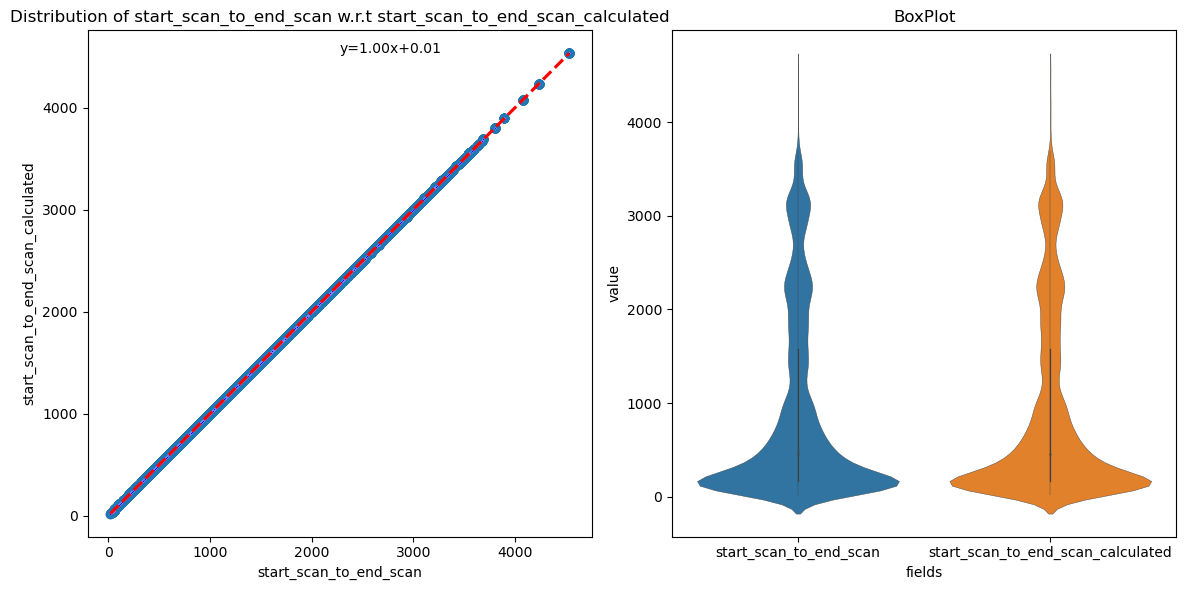

In [501]:
hypothesis_test(training_data,'start_scan_to_end_scan','start_scan_to_end_scan_calculated')

#Considering the distribution plot, start_scan_to_end_scan field doesn't have any anamolies 

<span style="font-size: 15px;">Comparing actual_time aggregated value and OSRM time aggregated value</span>

t_stat: -217.11199086579094 with p_value: 0.0
There is a statistically significant difference between the means of the two related samples.
correlation: 0.9779549584278064 with p_value: 0.0
There is a statistically significant linear correlation between the two variables.
Equation:  y=1.89x+11.21


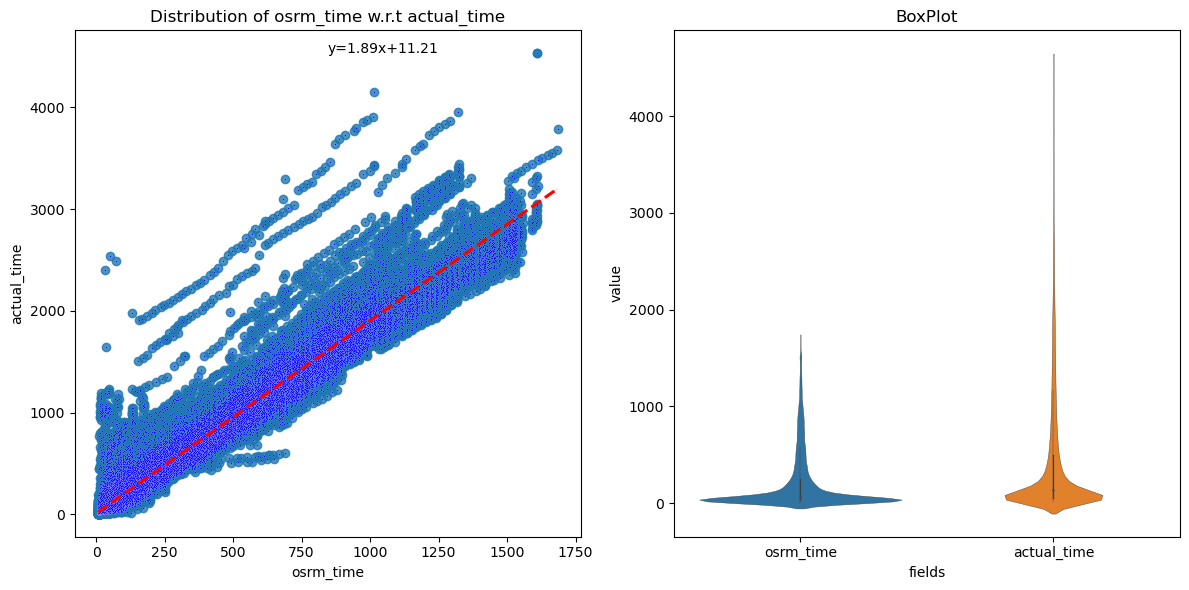

In [502]:
hypothesis_test(training_data,'osrm_time','actual_time')

#From the plots, it seems osrm is underestimating the time required to take a trip (actual time taken is almost twice osrm time)

<span style="font-size: 15px;">Comparing actual time aggregated and segment time </span>

t_stat: -46.348820538820576 with p_value: 0.0
There is a statistically significant difference between the means of the two related samples.
correlation: 0.998982245311161 with p_value: 0.0
There is a statistically significant linear correlation between the two variables.
Equation:  y=1.00x+0.40


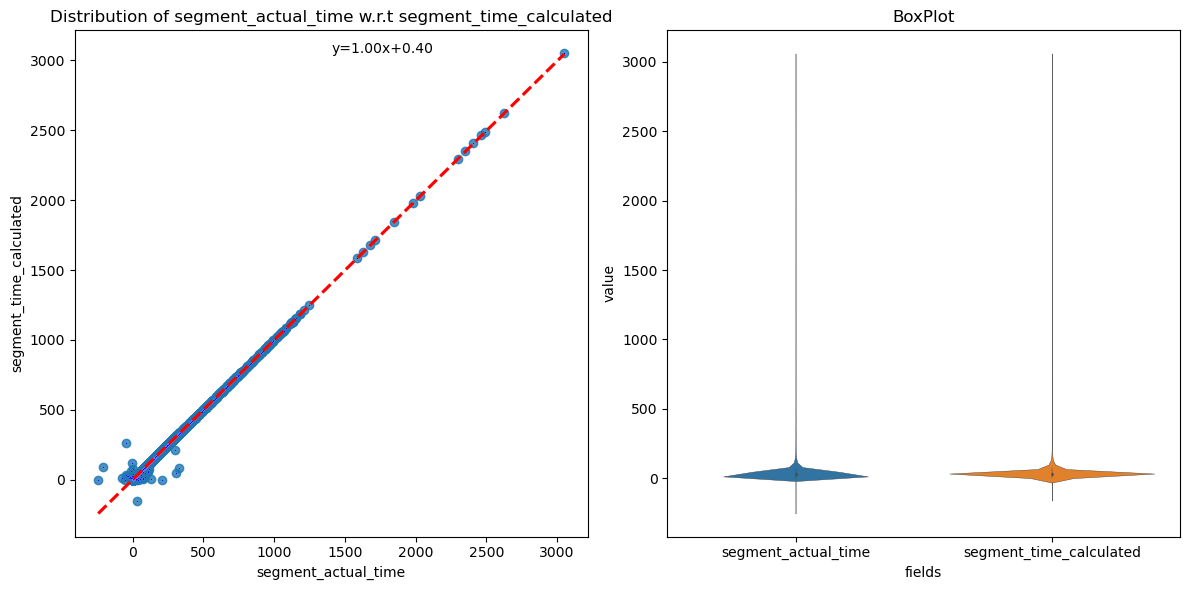

In [503]:
hypothesis_test(training_data,'segment_actual_time','segment_time_calculated')

<span style="font-size: 15px;">Comparing osrm distance aggregated value and segment osrm distance aggregated value</span>

t_stat: 63.87878528483581 with p_value: 0.0
There is a statistically significant difference between the means of the two related samples.
correlation: 0.8621148394923512 with p_value: 0.0
There is a statistically significant linear correlation between the two variables.
Equation:  y=0.84x+1.82


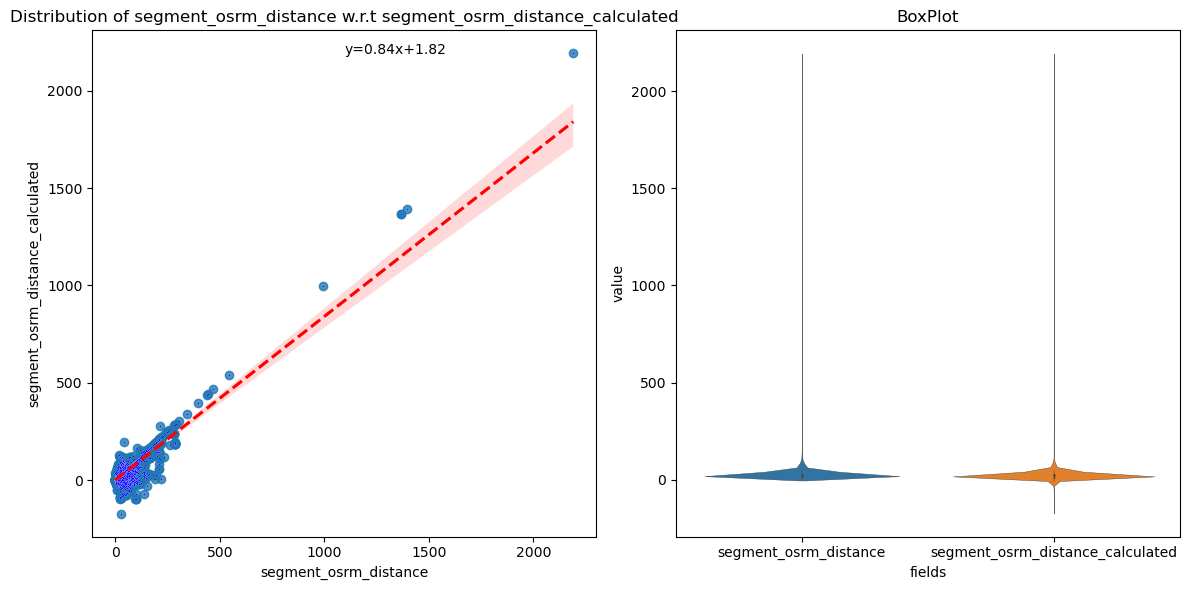

In [504]:
hypothesis_test(training_data,'segment_osrm_distance','segment_osrm_distance_calculated')

# major anamolies observed in data with segment_osrm_distance>segment_osrm_distance_calculated(aggregated from cumulative osrm distances) 
# this seems logical considering cumulative osrm distance are not taking into consideration the stops along the way while estimating the trip distance left to cover

<span style="font-size: 15px;">osrm time aggregated value and segment osrm time aggregated value</span>

t_stat: 76.54481656206259 with p_value: 0.0
There is a statistically significant difference between the means of the two related samples.
correlation: 0.8417139892822456 with p_value: 0.0
There is a statistically significant linear correlation between the two variables.
Equation:  y=0.80x+1.82


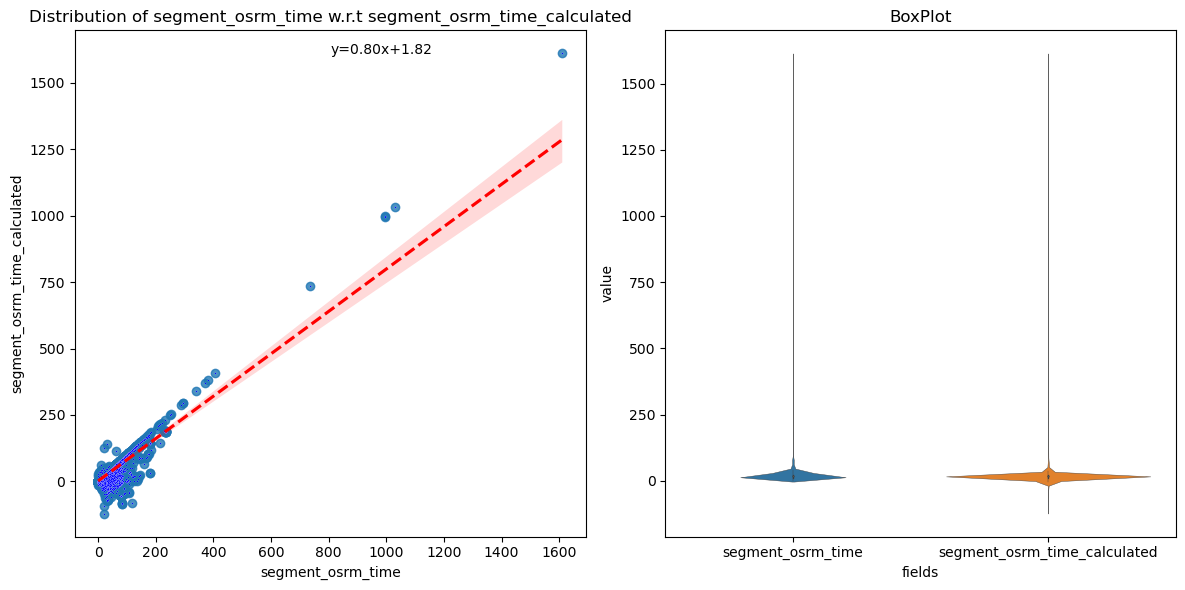

In [505]:
hypothesis_test(training_data,'segment_osrm_time','segment_osrm_time_calculated')

# major anamolies observed in data with segment_osrm_time>segment_osrm_time_calculated(aggregated) 
# Again, this seems logical considering cumulative osrm distance are not taking into consideration the stops along the way while estimating the trip distance left to cover


<span style="font-size: 18px;">Missing Values, Outlier Treatment and further Field creations</span>

In [509]:
def handling_missing_states(data):
    d=data.copy()
    d=d.sort_values('cutoff_timestamp',ascending=True)
    d.reset_index(inplace=True,drop=True)
    
    d['prev_source_center']=d.source_center.shift(periods=1)
    d['prev_source_state']=d.Source_State.shift(periods=-1)
    d['prev_destination_center']=d.destination_center.shift(periods=1)
    
    
    d['next_source_center']=d.source_center.shift(periods=-1)
    d['next_destination_center']=d.destination_center.shift(periods=-1)
    d['next_destination_state']=d.Destination_State.shift(periods=-1)
    
    ss=d.loc[((d.destination_center==d.next_source_center)|(d.next_source_center.isna()))&\
                (d.destination_name.isna()),['destination_center','next_source_center','Source_State','next_destination_state']].copy()
    ss.loc[~(ss.destination_center==ss.next_source_center),'next_destination_state']=None
    ss=ss[['destination_center','Source_State','next_destination_state']].copy()
    ss.columns=['center','source_state','destination_state']
    
    ss1=d.loc[((d.source_center==d.prev_destination_center)|(d.prev_destination_center.isna()))&\
                (d.source_center.isna()),['source_center','prev_destination_center','prev_source_state','Destination_State']].copy()
    ss1.loc[~(ss1.source_center==ss1.prev_destination_center),'prev_source_state']=None
    ss1=ss1[['source_center','prev_source_state','Destination_State']].copy()
    ss1.columns=['center','source_state','destination_state']
    ss=pd.concat([ss,ss1],axis=0,ignore_index=True)
    ss.drop_duplicates(keep='first',inplace=True)
    ss['possible_state']=None
    ss.loc[((ss.destination_state.isna())&(~(ss.source_state.isna()))),'possible_state']=ss.loc[((ss.destination_state.isna())&(~(ss.source_state.isna()))),'source_state']
    ss.loc[((ss.source_state.isna())&(~(ss.destination_state.isna()))),'possible_state']=ss.loc[((ss.source_state.isna())&(~(ss.destination_state.isna()))),'destination_state']
    ss.loc[(~(ss.source_state.isna())&(~(ss.destination_state.isna())))&\
           (ss.source_state==ss.destination_state),'possible_state']=ss.loc[(~(ss.source_state.isna())&(~(ss.destination_state.isna())))&\
                                                   (ss.source_state==ss.destination_state),'source_state']
    return ss


def treat_outliers(data,col,low_ext,up_ext):
    s=data[col].describe()
    le=s['25%']-1.5*(s['75%']-s['25%'])
    ue=s['75%']+1.5*(s['75%']-s['25%'])
    d=data.copy()
    if low_ext:
        d.loc[d[col]<le,col]=le
    if up_ext:
        d.loc[d[col]>ue,col]=ue
    return d[col],le,ue

    
def broad_aggregation2(data):
    #After Outlier treatment
    d=data.copy()
    d=d.sort_values('cutoff_timestamp',ascending=False)
    
    d.reset_index(inplace=True,drop=True)
    d['segment_speed_calculated']=(d.segment_distance_calculated/d.segment_actual_time)
    d.loc[(d.segment_actual_time<=0)|(d.segment_distance_calculated<0),'segment_speed_calculated']=0
    d['segment_osrm_speed_calculated']=(d.segment_osrm_distance/d.segment_osrm_time)
    d.loc[(d.segment_osrm_time<=0)|(d.segment_osrm_distance<0),'segment_osrm_speed_calculated']=0

    ##segment 1 distance=(total trip time-sum(successive segment times))*average(segment actual speed)
    
    d['total_trip_distance']=(d['start_scan_to_end_scan_calculated']-d['segment_actual_time'].sum())*(d['segment_speed_calculated'].mean())+\
                              d['segment_distance_calculated'].sum()

    ##assuming first segment covered is same from osrm and actual
    
    d['total_osrm_time']=((d['start_scan_to_end_scan_calculated']-d['segment_actual_time'].sum())*(d['segment_speed_calculated'].mean())/d['segment_osrm_speed_calculated'].mean())+\
         d.segment_osrm_time.sum()
    d['total_osrm_trip_distance']=(d['start_scan_to_end_scan_calculated']-d['segment_actual_time'].sum())*(d['segment_speed_calculated'].mean())+\
                              d['segment_osrm_distance'].sum()


    return d



<span style="font-size: 18px;">Missing Values Treatment</span>

In [510]:

## if paths are: known State1->unknown State->known State1, then unknown State = known State1
#                known State1->unknown State(last destination in route), then unknown State = known State1
#                unknown State(first source in route)->known State1, then unknown State = known State1
#                known State1->unknown State->known State2, then unknown State = known State1
#                else the route is removed from data dump


from collections import defaultdict
def def_value(): 
    return 'Not Present'

# ALL CENTERS AND STATES FROM TRAINING DATA
centers_dict = defaultdict(def_value)

nan_centers=training_data.groupby(['trip_creation_time','route_schedule_uuid']).apply(handling_missing_states).droplevel(-1).reset_index()
for ind,row in nan_centers.iterrows():
    if centers_dict[row['center']]=='Not Present':
        centers_dict[row['center']]=row['possible_state']
        

sc=training_data.loc[:,['source_center','Source_State']].copy()
dt=training_data.loc[:,['destination_center','Destination_State']].copy()
dt.columns=['source_center','Source_State']
sc=pd.concat([sc,dt],axis=0,ignore_index=True)
sc.drop_duplicates(keep='first',inplace=True)
for ind,row in sc.iterrows():
    if centers_dict[row['source_center']]=='Not Present':
        centers_dict[row['source_center']]=row['Source_State']

nan_centers.loc[:,'possible_state']=nan_centers.center.map(centers_dict)
nan_centers.loc[nan_centers.possible_state.isna(),'possible_state']=nan_centers.loc[nan_centers.possible_state.isna(),'source_state']


## Removing the states that can't be predicted

n=nan_centers.loc[nan_centers.possible_state.isna(),['trip_creation_time','route_schedule_uuid']].copy()
n.drop_duplicates(keep='first',inplace=True)
n['index']=1
n=n[['trip_creation_time','route_schedule_uuid','index']].copy()
columns=training_data.columns
training_data=training_data.merge(n,how='left',on=['trip_creation_time','route_schedule_uuid'])
training_data=training_data.loc[training_data['index'].isna(),columns].copy()

for ind,row in nan_centers.iterrows():
    if centers_dict[row['center']]=='Not Present':
        centers_dict[row['center']]=row['possible_state']
        
training_data.loc[:,'Source_State']=training_data.loc[:,'source_center'].map(centers_dict)
training_data.loc[:,'Destination_State']=training_data.loc[:,'destination_center'].map(centers_dict)
training_data.reset_index(drop=True,inplace=True)

In [511]:
nan_centers ##NaN centers
## path: source_state->unknown center->destination_center

,trip_creation_time,route_schedule_uuid,center,source_state,destination_state,possible_state
0,2018-09-19 05:45:26,thanos::sroute:e591febd-564c-499a-ad94-6fa4b7f...,IND122015AAC,Haryana,None,Haryana
1,2018-09-19 20:57:33,thanos::sroute:d0ebdacd-e09b-47d3-be77-c9c4a05...,IND577116AAA,Karnataka,Karnataka,Karnataka
2,2018-09-19 22:58:44,thanos::sroute:0fe10045-cf65-4c70-8115-4e4cf80...,IND505326AAB,Telangana,None,Telangana
3,2018-09-20 03:43:39,thanos::sroute:e591febd-564c-499a-ad94-6fa4b7f...,IND122015AAC,Haryana,None,Haryana
4,2018-09-21 19:45:14,thanos::sroute:da7a341a-ba3d-436d-b4b5-607d1a0...,IND509103AAC,Telangana,Andhra Pradesh,Telangana
5,2018-09-22 09:27:46,thanos::sroute:4460a38d-ab9b-484e-bd4e-f4201d0...,IND342902A1B,Rajasthan,Rajasthan,Rajasthan
6,2018-09-22 20:56:58,thanos::sroute:d0ebdacd-e09b-47d3-be77-c9c4a05...,IND577116AAA,Karnataka,None,Karnataka
7,2018-09-23 08:34:25,thanos::sroute:4460a38d-ab9b-484e-bd4e-f4201d0...,IND342902A1B,Rajasthan,Rajasthan,Rajasthan
8,2018-09-23 21:51:24,thanos::sroute:a8dd8c7f-c295-4785-9e9c-53fcd13...,IND852118A1B,Bihar,None,Bihar
9,2018-09-24 07:18:06,thanos::sroute:2f43f11e-d3ba-4590-9355-82928e1...,IND282002AAD,Uttar Pradesh,None,Uttar Pradesh


In [512]:
centers_dict ##To further manipulate nan Test data

defaultdict(<function __main__.def_value()>,
            {'IND122015AAC': 'Haryana',
             'IND577116AAA': 'Karnataka',
             'IND505326AAB': 'Telangana',
             'IND509103AAC': None,
             'IND342902A1B': 'Rajasthan',
             'IND852118A1B': 'Bihar',
             'IND282002AAD': 'Uttar Pradesh',
             'IND841301AAC': 'Bihar',
             'IND465333A1B': 'Madhya Pradesh',
             'IND331001A1C': None,
             'IND209304AAA': 'Uttar Pradesh',
             'IND462022AAA': 'Madhya Pradesh',
             'IND561203AAB': 'Karnataka',
             'IND572101AAA': 'Karnataka',
             'IND000000ACB': 'Haryana',
             'IND562132AAA': 'Karnataka',
             'IND400072AAB': 'Maharashtra',
             'IND583101AAA': 'Karnataka',
             'IND583119AAA': 'Karnataka',
             'IND583201AAA': 'Karnataka',
             'IND600056AAA': 'Tamil Nadu',
             'IND600116AAB': 'Tamil Nadu',
             'IND600044AAD': 'Tamil

In [513]:
## Filling Test Data Missing States ##
test_data.loc[test_data.Source_State.isna(),'Source_State']=test_data.loc[test_data.Source_State.isna()].source_center.map(centers_dict)
test_data.loc[test_data.Destination_State.isna(),'Destination_State']=test_data.loc[test_data.Destination_State.isna()].destination_center.map(centers_dict)
n=test_data.loc[(test_data.Source_State.isna())|(test_data.Destination_State.isna()),['trip_creation_time','route_schedule_uuid']].copy()
n.drop_duplicates(keep='first',inplace=True)
n['index']=1
columns=test_data.columns
test_data=test_data.merge(n,how='left',on=['trip_creation_time','route_schedule_uuid'])
test_data=test_data.loc[test_data['index'].isna(),columns].copy()




<span style="font-size: 15px;">Outlier Treatment</span>

In [514]:
training_data.loc[:,'segment_actual_time'],segment_actual_time_le,segment_actual_time_ue=treat_outliers(training_data,'segment_actual_time',True,True)   
test_data.loc[test_data['segment_actual_time']<segment_actual_time_le,'segment_actual_time']=segment_actual_time_le
test_data.loc[test_data['segment_actual_time']>segment_actual_time_ue,'segment_actual_time']=segment_actual_time_ue

training_data.loc[:,'segment_osrm_time'],segment_osrm_time_le,segment_osrm_time_ue=treat_outliers(training_data,'segment_osrm_time',True,True)
test_data.loc[test_data['segment_osrm_time']<segment_osrm_time_le,'segment_osrm_time']=segment_osrm_time_le
test_data.loc[test_data['segment_osrm_time']>segment_osrm_time_ue,'segment_osrm_time']=segment_osrm_time_ue

training_data.loc[:,'segment_osrm_distance'],segment_osrm_distance_le,segment_osrm_distance_ue=treat_outliers(training_data,'segment_osrm_distance',True,True)
test_data.loc[test_data['segment_osrm_distance']<segment_osrm_distance_le,'segment_osrm_distance']=segment_osrm_distance_le
test_data.loc[test_data['segment_osrm_distance']>segment_osrm_distance_ue,'segment_osrm_distance']=segment_osrm_distance_ue

In [515]:
##Adding few more Fields
training_data=training_data.groupby(['trip_creation_time','route_schedule_uuid'
                       ,'trip_uuid','source_center','destination_center'
                      ]).apply(broad_aggregation2).reset_index(drop=True)

test_data=test_data.groupby(['trip_creation_time','route_schedule_uuid'
                       ,'trip_uuid','source_center','destination_center'
                      ]).apply(broad_aggregation2).reset_index(drop=True)

<span style="font-size: 18px;">Analysis/Recommendations</span>

In [516]:
def route_agg1(data):
    d=data[['trip_uuid','source_center','destination_center']].copy()
    d.drop_duplicates(keep='first',inplace=True)
    return len(d)

    
def state_trip_agg(data):
    total_routes=data.route_schedule_uuid.nunique()
    total_trips=data.groupby(['trip_creation_time','route_schedule_uuid']).apply(route_agg1)
    avg_trips_per_route=total_trips.mean()

    total_stops=data.groupby(['trip_creation_time','route_schedule_uuid']).trip_uuid.count()
    avg_stops_per_route=total_stops.mean()

    d=data[['trip_creation_time','route_schedule_uuid','trip_uuid','total_trip_distance'
          ,'total_osrm_trip_distance','total_osrm_time','start_scan_to_end_scan_calculated']].copy()
    d.drop_duplicates(keep='first',inplace=True)
    
    avg_trip_distance=d.total_trip_distance.mean()
    avg_osrm_trip_distance=d.total_osrm_trip_distance.mean()
    avg_start_scan_to_end_scan_calculated=d.start_scan_to_end_scan_calculated.mean()
    avg_osrm_trip_time=d.total_osrm_time.mean()
    
    distance_from_xy=round(abs(avg_osrm_trip_distance-avg_trip_distance),2)
    time_from_xy=round(abs(avg_osrm_trip_time-avg_start_scan_to_end_scan_calculated),2)

    return pd.DataFrame([[total_routes,avg_trips_per_route,avg_stops_per_route
                   ,avg_trip_distance,avg_osrm_trip_distance,avg_osrm_trip_time
                    ,avg_start_scan_to_end_scan_calculated,distance_from_xy,time_from_xy]]
                 ,columns=['total_routes','avg_trips_per_route','avg_stops_per_route'
                   ,'avg_trip_distance','avg_osrm_trip_distance','avg_osrm_trip_time','avg_start_scan_to_end_scan_calculated'
                           ,'distance_from_xy','time_from_xy'])
    



In [517]:
t1=training_data.groupby(['cutoff_is_weekend','cutoff_time_of_day','route_type']).apply(state_trip_agg).droplevel(-1).reset_index()


In [518]:
t1['combo']='<b>'+t1['cutoff_is_weekend'].apply(lambda x:'Weekday-' if x==0 else 'Weekend-')+t1['cutoff_time_of_day']+' ('+t1['route_type']+') </b><br>'+\
            'Distance Difference: '+t1['distance_from_xy'].astype(str)
t1['total_routes_scaled']=10*(t1['total_routes']-t1['total_routes'].min())/(
                            t1['total_routes'].max()-t1['total_routes'].min())

t1['combo_time']='<b>'+t1['cutoff_is_weekend'].apply(lambda x:'Weekday-' if x==0 else 'Weekend-')+t1['cutoff_time_of_day']+' ('+t1['route_type']+') </b><br>'+\
            'Time Difference: '+t1['time_from_xy'].astype(str)
t1.to_excel('t111.xlsx',index=False)

In [519]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [520]:
t11=t1.loc[t1.route_type=='FTL'].copy()
t12=t1.loc[t1.route_type=='Carting'].copy()

def graph(t1,l,u,rt,g,off):
    y0=t1['avg_trip_distance'].min()-2
    y1=t1['avg_trip_distance'].max()+2
    
    x0=t1['avg_osrm_trip_distance'].min()-2
    x1=t1['avg_osrm_trip_distance'].max()+2
    fig=px.scatter(
                data_frame=t1
                , y='avg_trip_distance'
                , x='avg_osrm_trip_distance'
                , size='total_routes_scaled'
                #, color='Decline'
                #, color_discrete_map=color_map
                , height=800
                , width=1000
                , text='combo'
        
            )
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False,title='Average OSRM trip distance (Km)'
                             , range=[x0-l,x1+u]
                             #, tickvals=x_ticks
                             #, ticktext=["{}%".format(round(i*100,0)) for i in x_ticks]
                              
                            )
                  , xaxis_title_font=dict(color='black',size=14)
                  ,yaxis=dict(showgrid=False,title='Average Actual trip distance (Km)'
                            , range=[y0-5,y1+10]
                            # , tickvals=y_ticks
                             #, ticktext=["${}".format(i) if i>=0 else "$({})".format(-1*i) for i in y_ticks]
                                )
                 , yaxis_title_font=dict(color='black',size=14)
                 , title={'text':'<b>Comparison of Average OSRM and Actual Distances by Time of Day and Day Type</b><br>Route Type: {}<br><span style="font-size: 10px;">size of bubble represents total routes</span>'.format(rt)
                         , 'font':{'size':15,'color':'black'}}
                  ,title_x=0.5
                  #,legend=dict(title='',x=0.025,y=1,orientation='v',traceorder='normal')
                 )
    
    
    
    fig.add_shape(type='line',x0=min(x0-l,y0-5),y0=min(x0-l,y0-5),x1=min(x1+u,y1+10),y1=min(x1+u,y1+10),line=dict(dash='dash',color='#FFA3A3'))
    
    fig.update_traces( textfont_size=10,textposition='middle right',textfont_color='#C00000') #marker=dict(color=fraud_players['color'].values)
                     
    fig.update_xaxes(showline=True,linewidth=1,linecolor='black')
    fig.update_yaxes(showline=True,linewidth=1,linecolor='black')
    fig.add_annotation(text='<b>45 degree line</b>', textangle=g, visible=True,font_color='#FFA3A3'
                           ,showarrow=False,x=((min(x0-l,y0-5)+min(x1+u,y1+10))/2)-off,y=(min(x0-l,y0-5)+min(x1+u,y1+10))/2)
    pio.write_image(fig,r'Distance_{}.png'.format(rt),scale=2)
    fig.show()

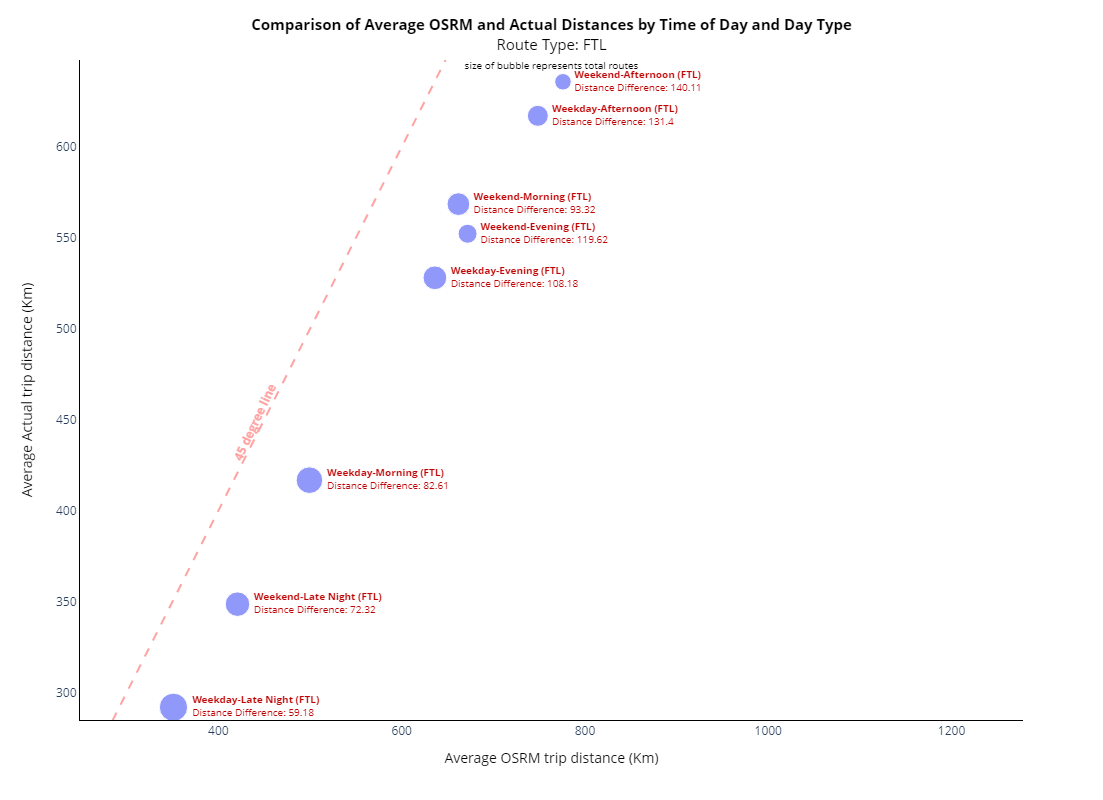

In [521]:
graph(t11,100,500,'FTL',-65,10)

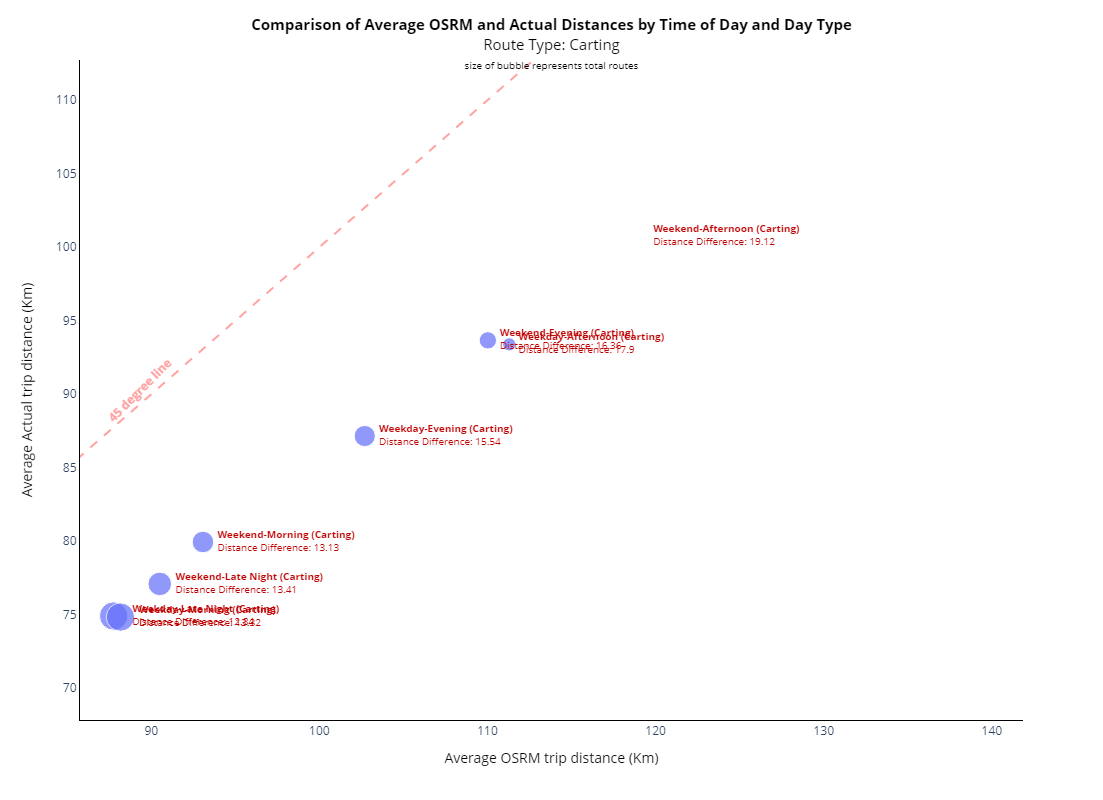

In [522]:
graph(t12,0,20,'Carting',-45,1)

In [523]:
def graph1(t1,l,u,rt,g,off):
    y0=t1['avg_start_scan_to_end_scan_calculated'].min()-2
    y1=t1['avg_start_scan_to_end_scan_calculated'].max()+2
    
    x0=t1['avg_osrm_trip_time'].min()-2
    x1=t1['avg_osrm_trip_time'].max()+2
    fig=px.scatter(
                data_frame=t1
                , y='avg_start_scan_to_end_scan_calculated'
                , x='avg_osrm_trip_time'
                , size='total_routes_scaled'
                #, color='Decline'
                #, color_discrete_map=color_map
                , height=800
                , width=1000
                , text='combo_time'
        
            )
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False,title='Average OSRM trip time (Mins)'
                             , range=[x0-l,x1+u]
                             #, tickvals=x_ticks
                             #, ticktext=["{}%".format(round(i*100,0)) for i in x_ticks]
                              
                            )
                  , xaxis_title_font=dict(color='black',size=14)
                  ,yaxis=dict(showgrid=False,title='Average Actual trip time (Mins)'
                            , range=[y0-10,y1+20]
                            # , tickvals=y_ticks
                             #, ticktext=["${}".format(i) if i>=0 else "$({})".format(-1*i) for i in y_ticks]
                                )
                 , yaxis_title_font=dict(color='black',size=14)
                 , title={'text':'<b>Comparison of Average OSRM and Actual Times by Time of Day and Day Type</b><br>Route Type: {}<br><span style="font-size: 10px;">size of bubble represents total routes</span>'.format(rt)
                         , 'font':{'size':15,'color':'black'}}
                  ,title_x=0.5
                  #,legend=dict(title='',x=0.025,y=1,orientation='v',traceorder='normal')
                 )
    
    
    
    fig.add_shape(type='line',x0=min(x0-l,y0-10),y0=min(x0-l,y0-10),x1=min(x1+u,y1+20),y1=min(x1+u,y1+20),line=dict(dash='dash',color='#FFA3A3'))
    
    fig.update_traces( textfont_size=10,textposition='middle right',textfont_color='#C00000') #marker=dict(color=fraud_players['color'].values)
                     
    fig.update_xaxes(showline=True,linewidth=1,linecolor='black')
    fig.update_yaxes(showline=True,linewidth=1,linecolor='black')
    fig.add_annotation(text='<b>45 degree line</b>', textangle=g, visible=True,font_color='#FFA3A3'
                           ,showarrow=False,x=((min(x0-l,y0-5)+min(x1+u,y1+10))/2)-off,y=(min(x0-l,y0-5)+min(x1+u,y1+10))/2)
    pio.write_image(fig,r'Time_{}.png'.format(rt),scale=2)
    fig.show()

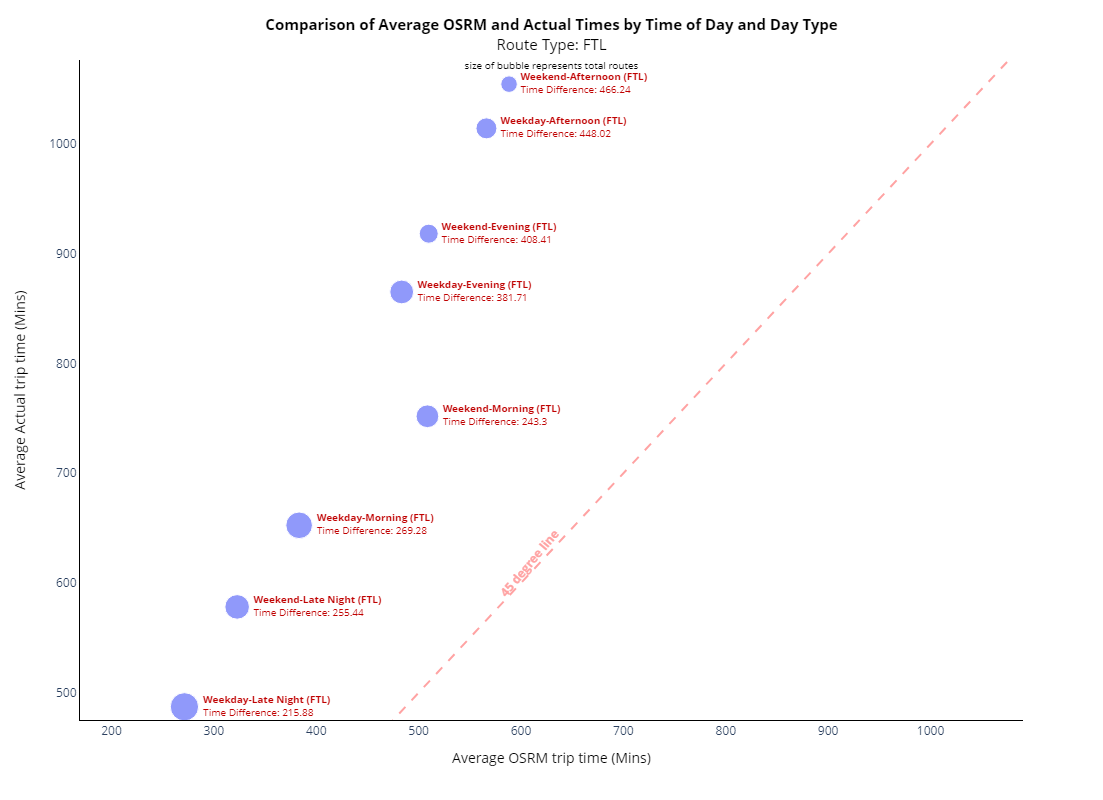

In [524]:
graph1(t11,100,500,'FTL',-50,10)

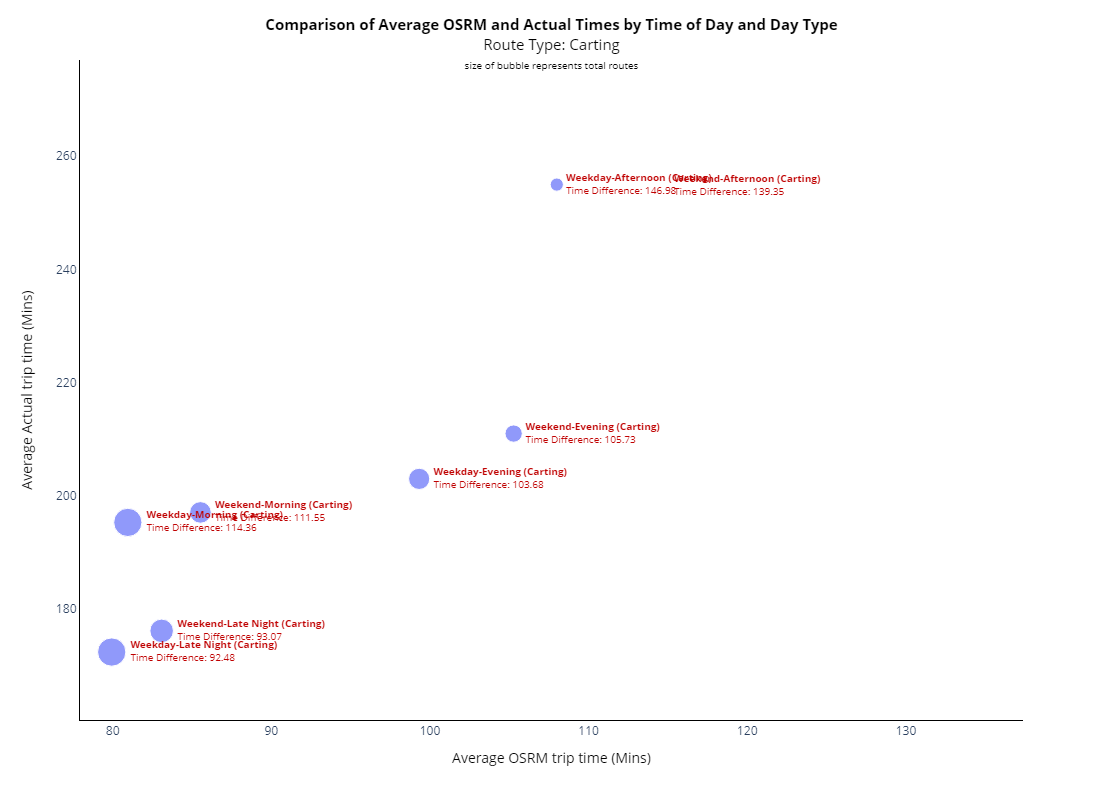

In [525]:
graph1(t12,0,20,'Carting',-50,0)

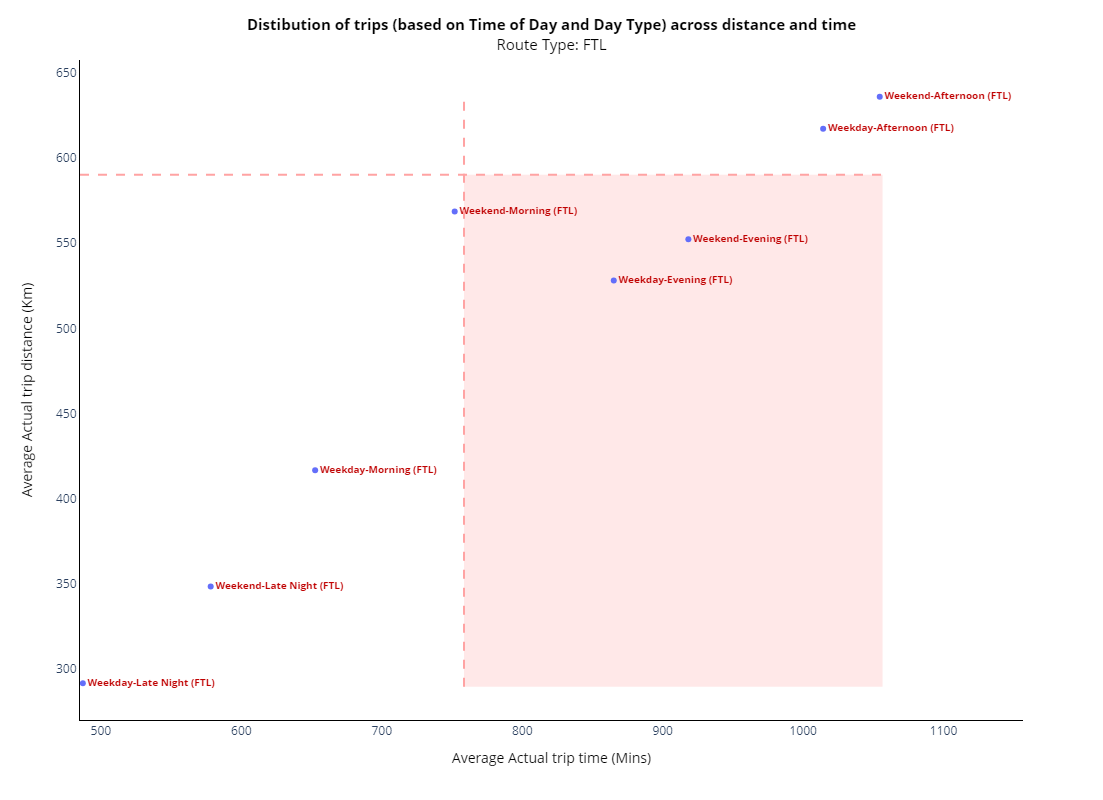

In [526]:
def graph2(t11,k,rt,k1):
    t1=t11.copy()
    y0=t1['avg_trip_distance'].min()-2
    y1=t1['avg_trip_distance'].max()+2
    
    x0=t1['avg_start_scan_to_end_scan_calculated'].min()-2
    x1=t1['avg_start_scan_to_end_scan_calculated'].max()+2
    avg_time=t1.avg_start_scan_to_end_scan_calculated.median()-k
    avg_distance=t1.avg_trip_distance.median()+k

    t1['combo']='<b>'+t1['cutoff_is_weekend'].apply(lambda x:'Weekday-' if x==0 else 'Weekend-')+t1['cutoff_time_of_day']+' ('+t1['route_type']+') </b>'
    #t1.loc[~((t1.avg_start_scan_to_end_scan_calculated>=avg_time)&\
     #     (t1.avg_trip_distance<=avg_distance)),'combo']=None
    
    fig=px.scatter(
                data_frame=t1
                , y='avg_trip_distance'
                , x='avg_start_scan_to_end_scan_calculated'
                #, size='total_routes_scaled'
                #, color='Decline'
                #, color_discrete_map=color_map
                , height=800
                , width=1000
                , text='combo'
        
            )
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False,title='Average Actual trip time (Mins)'
                             , range=[x0,x1+k1]
                             #, tickvals=x_ticks
                             #, ticktext=["{}%".format(round(i*100,0)) for i in x_ticks]
                              
                            )
                  , xaxis_title_font=dict(color='black',size=14)
                  ,yaxis=dict(showgrid=False,title='Average Actual trip distance (Km)'
                            #, range=[y0-2,y1+2]
                            # , tickvals=y_ticks
                             #, ticktext=["${}".format(i) if i>=0 else "$({})".format(-1*i) for i in y_ticks]
                                )
                 , yaxis_title_font=dict(color='black',size=14)
                 , title={'text':'<b>Distibution of trips (based on Time of Day and Day Type) across distance and time</b><br>Route Type: {}'.format(rt)
                         , 'font':{'size':15,'color':'black'}}
                  ,title_x=0.5
                  #,legend=dict(title='',x=0.025,y=1,orientation='v',traceorder='normal')
                 )
    
    
    
    fig.add_shape(type='line',x0=avg_time,y0=y0,x1=avg_time,y1=y1,line=dict(dash='dash',color='#FFA3A3'))
    fig.add_shape(type='line',x0=x0,y0=avg_distance,x1=x1,y1=avg_distance,line=dict(dash='dash',color='#FFA3A3'))
    
    
    fig.add_shape(type='path',path='M {} {} L {} {} L {} {} L {} {} Z'.format(avg_time,y0
                                                                           ,avg_time,avg_distance
                                                                           ,x1,avg_distance
                                                                           ,x1,y0)
                   ,fillcolor='rgba(255,183,183,0.3)'
                  ,layer='below',line=dict(width=0))
    
    fig.update_traces( textfont_size=10,textposition='middle right',textfont_color='#C00000') #marker=dict(color=fraud_players['color'].values)
                     
    fig.update_xaxes(showline=True,linewidth=1,linecolor='black')
    fig.update_yaxes(showline=True,linewidth=1,linecolor='black')
    pio.write_image(fig,'efficient_{}.png'.format(rt),scale=2)
    fig.show()


graph2(t11,50,'FTL',100)

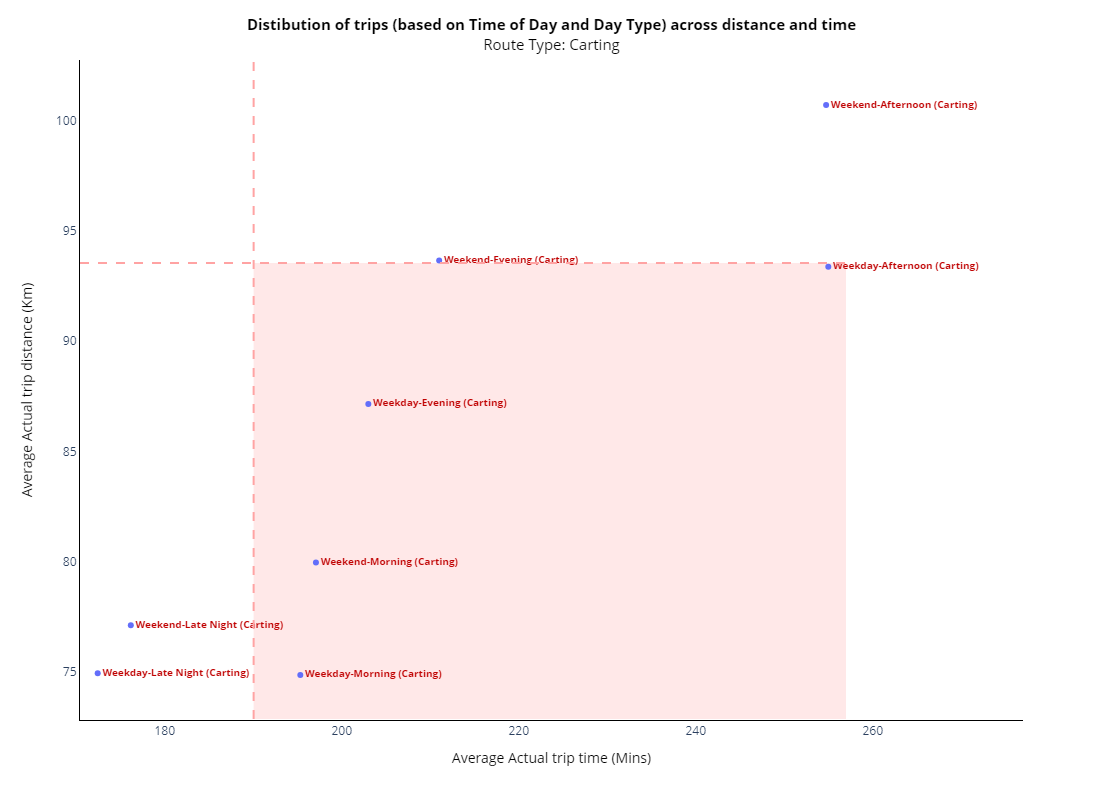

In [527]:
graph2(t12,10,'Carting',20)

In [528]:
t=training_data.groupby(['Source_State','Destination_State']).apply(state_trip_agg).droplevel(-1).reset_index()
avg_time=t.avg_start_scan_to_end_scan_calculated.median()-20
avg_distance=t.avg_trip_distance.median()+20

t['combo']=t['Source_State']+'-'+t['Destination_State']
t.loc[~((t.avg_start_scan_to_end_scan_calculated>=avg_time)&\
      (t.avg_trip_distance<=avg_distance)),'combo']=None


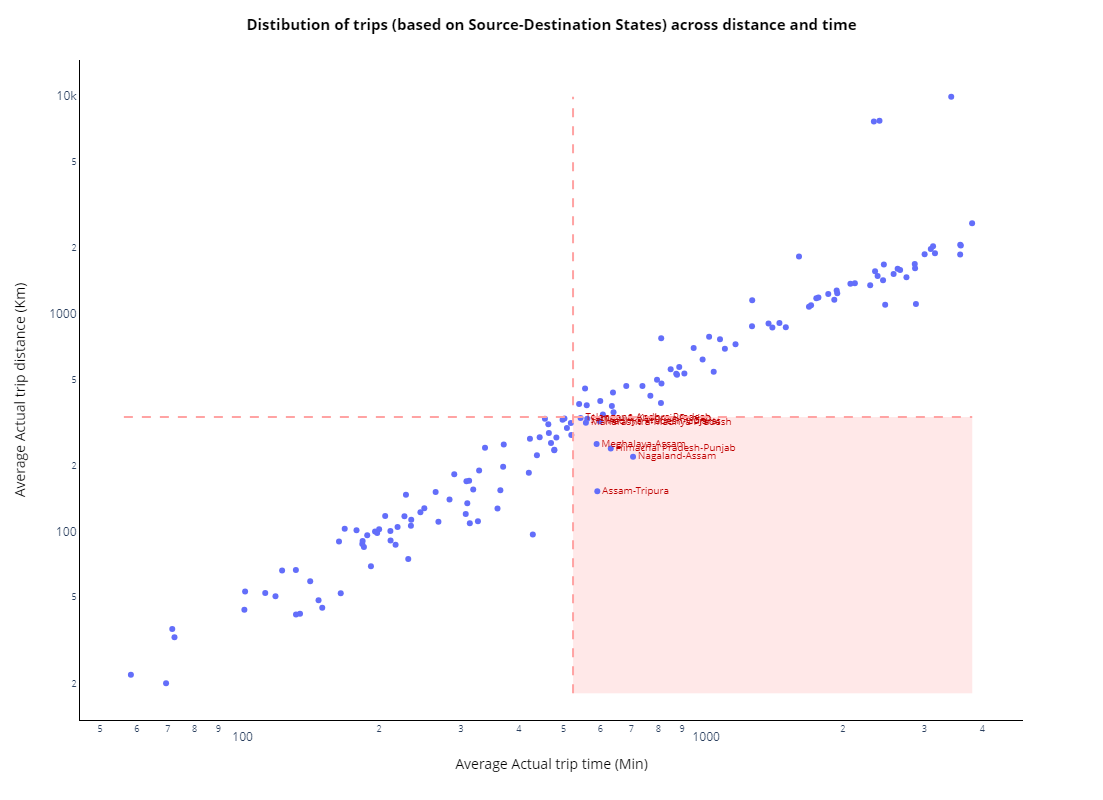

In [529]:
y0=t['avg_trip_distance'].min()-2
y1=t['avg_trip_distance'].max()+2

x0=t['avg_start_scan_to_end_scan_calculated'].min()-2
x1=t['avg_start_scan_to_end_scan_calculated'].max()+2
fig=px.scatter(
            data_frame=t
            , y='avg_trip_distance'
            , x='avg_start_scan_to_end_scan_calculated'
            #, size='total_routes_scaled'
            #, color='Decline'
            #, color_discrete_map=color_map
            , height=800
            , width=1000
            , text='combo'
            ,log_y=True
            ,log_x=True
        )

fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False,title='Average Actual trip time (Min)'
                             #, range=[x0,x1+10]
                             #, tickvals=x_ticks
                             #, ticktext=["{}%".format(round(i*100,0)) for i in x_ticks]
                              
                            )
                  , xaxis_title_font=dict(color='black',size=14)
                  ,yaxis=dict(showgrid=False,title='Average Actual trip distance (Km)'
                            #, range=[y0-2,y1+2]
                            # , tickvals=y_ticks
                             #, ticktext=["${}".format(i) if i>=0 else "$({})".format(-1*i) for i in y_ticks]
                                )
                 , yaxis_title_font=dict(color='black',size=14)
                 , title={'text':'<b>Distibution of trips (based on Source-Destination States) across distance and time</b>'
                         , 'font':{'size':15,'color':'black'}}
                  ,title_x=0.5
                  #,legend=dict(title='',x=0.025,y=1,orientation='v',traceorder='normal')
                 )



fig.add_shape(type='line',x0=avg_time,y0=y0,x1=avg_time,y1=y1,line=dict(dash='dash',color='#FFA3A3'))
fig.add_shape(type='line',x0=x0,y0=avg_distance,x1=x1,y1=avg_distance,line=dict(dash='dash',color='#FFA3A3'))


fig.add_shape(type='path',path='M {} {} L {} {} L {} {} L {} {} Z'.format(avg_time,y0
                                                                       ,avg_time,avg_distance
                                                                       ,x1,avg_distance
                                                                       ,x1,y0)
               ,fillcolor='rgba(255,183,183,0.3)'
              ,layer='below',line=dict(width=0))

fig.update_traces( textfont_size=10,textposition='middle right',textfont_color='#C00000') #marker=dict(color=fraud_players['color'].values)
                 
fig.update_xaxes(showline=True,linewidth=1,linecolor='black')
fig.update_yaxes(showline=True,linewidth=1,linecolor='black')
pio.write_image(fig,'Non_Efficient_states.png',scale=2)
fig.show()
t.to_excel('t1.xlsx',index=False)

In [536]:
t=training_data.groupby(['Source_State','Destination_State']).apply(state_trip_agg).droplevel(-1).reset_index()
avg_time=t.avg_start_scan_to_end_scan_calculated.median()-20
avg_osrm_time=t.avg_osrm_trip_time.median()+20

t['combo']=t['Source_State']+'-'+t['Destination_State']
t.loc[~((t.avg_start_scan_to_end_scan_calculated>=avg_time)&\
      (t.avg_osrm_trip_time<=avg_osrm_time)),'combo']=None


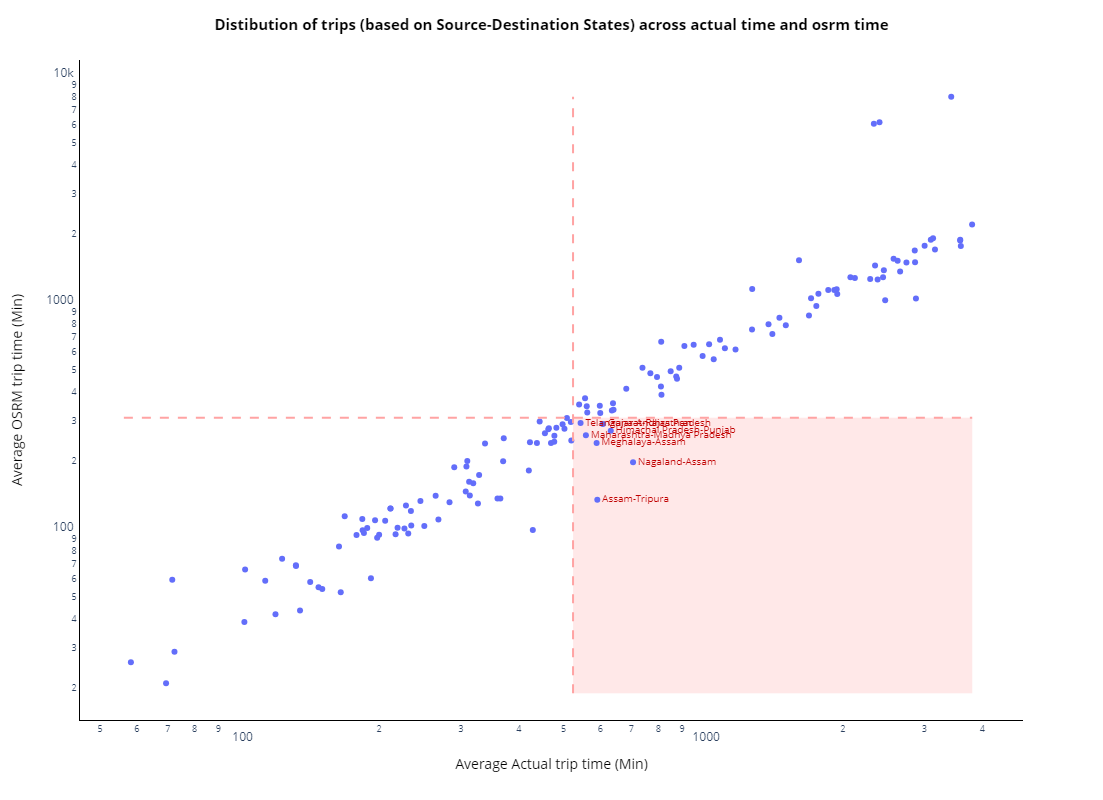

In [537]:
y0=t['avg_osrm_trip_time'].min()-2
y1=t['avg_osrm_trip_time'].max()+2

x0=t['avg_start_scan_to_end_scan_calculated'].min()-2
x1=t['avg_start_scan_to_end_scan_calculated'].max()+2
fig=px.scatter(
            data_frame=t
            , y='avg_osrm_trip_time'
            , x='avg_start_scan_to_end_scan_calculated'
            #, size='total_routes_scaled'
            #, color='Decline'
            #, color_discrete_map=color_map
            , height=800
            , width=1000
            , text='combo'
            ,log_y=True
            ,log_x=True
        )

fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False,title='Average Actual trip time (Min)'
                             #, range=[x0,x1+10]
                             #, tickvals=x_ticks
                             #, ticktext=["{}%".format(round(i*100,0)) for i in x_ticks]
                              
                            )
                  , xaxis_title_font=dict(color='black',size=14)
                  ,yaxis=dict(showgrid=False,title='Average OSRM trip time (Min)'
                            #, range=[y0-2,y1+2]
                            # , tickvals=y_ticks
                             #, ticktext=["${}".format(i) if i>=0 else "$({})".format(-1*i) for i in y_ticks]
                                )
                 , yaxis_title_font=dict(color='black',size=14)
                 , title={'text':'<b>Distibution of trips (based on Source-Destination States) across actual time and osrm time</b>'
                         , 'font':{'size':15,'color':'black'}}
                  ,title_x=0.5
                  #,legend=dict(title='',x=0.025,y=1,orientation='v',traceorder='normal')
                 )



fig.add_shape(type='line',x0=avg_time,y0=y0,x1=avg_time,y1=y1,line=dict(dash='dash',color='#FFA3A3'))
fig.add_shape(type='line',x0=x0,y0=avg_osrm_time,x1=x1,y1=avg_osrm_time,line=dict(dash='dash',color='#FFA3A3'))


fig.add_shape(type='path',path='M {} {} L {} {} L {} {} L {} {} Z'.format(avg_time,y0
                                                                       ,avg_time,avg_osrm_time
                                                                       ,x1,avg_osrm_time
                                                                       ,x1,y0)
               ,fillcolor='rgba(255,183,183,0.3)'
              ,layer='below',line=dict(width=0))

fig.update_traces( textfont_size=10,textposition='middle right',textfont_color='#C00000') #marker=dict(color=fraud_players['color'].values)
                 
fig.update_xaxes(showline=True,linewidth=1,linecolor='black')
fig.update_yaxes(showline=True,linewidth=1,linecolor='black')
#pio.write_image(fig,'Non_Efficient_states.png',scale=2)
fig.show()

<span style="font-size: 15px;">Standardizing Numeric data and partitioning non-numeric cols(using one-hot encoder) and adding everything in a pickle file</span>

In [395]:
Columns_needed=['route_type','start_scan_to_end_scan','actual_distance_to_destination','actual_time','osrm_time','osrm_distance'
             ,'segment_actual_time','segment_osrm_time','segment_osrm_distance', 'segment_distance_calculated'
             ,'cutoff_month','cutoff_day','cutoff_is_weekend','cutoff_time_of_day'
             ,'trip_creation_month','trip_creation_day','trip_creation_is_weekend','trip_creation_time_of_day'
             ,'od_start_time_month','od_start_time_day','od_start_time_is_weekend','od_start_time_of_day'
             ,'od_end_time_month','od_end_time_day','od_end_time_is_weekend','od_end_time_of_day'
             ,'Source_State','Destination_State'
             ,'total_trip_distance','total_osrm_trip_distance','total_osrm_time']

standardized_training_data=training_data.loc[:,Columns_needed].copy()
standardized_test_data=test_data.loc[:,Columns_needed].copy()


In [396]:
## one-hot encoder with non-numeric cols
def training_str_col(d):
    data=d.copy()
    drop_str_cols=[]
    str_cols=data.select_dtypes(['O']).columns
    for str_col in str_cols:
        str_data=pd.get_dummies(data.loc[:,str_col])
        str_data.columns=[str_col+'_'+col for col in str_data.columns]
        drop_str_cols.append(str_data.columns[-1])
        str_data.drop(str_data.columns[-1],axis=1,inplace=True)
    
        data.drop(str_col,axis=1,inplace=True)
        data=pd.concat([data,str_data],axis=1)
    return data,drop_str_cols

def test_str_col(d,drop_str_cols):
    data=d.copy()
    str_cols=data.select_dtypes(['O']).columns
    for str_col in str_cols:
        str_data=pd.get_dummies(data.loc[:,str_col])
        str_data.columns=[str_col+'_'+col for col in str_data.columns]
        data.drop(str_col,axis=1,inplace=True)
        data=pd.concat([data,str_data],axis=1)

    for drop_col in drop_str_cols:
        data.drop(drop_col,axis=1,inplace=True)
        
    return data

##standard scalar
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def filter_non_numeric(data,coll):
    enum_coll=list(enumerate(coll))
    #print(enum_coll)
    cols=data.select_dtypes(include=['number']).columns
    numeric_cols=list(set(cols).intersection(set(coll)))
    li=[sett[1] for sett in enum_coll if sett[1] in numeric_cols]
    return li
    
def standardize_data(d,cols,strategy='standard'):
    if strategy=='standard':
        scalar=StandardScaler()   
    else:
        scalar=MinMaxScaler()
    data=d.copy()
    cols=filter_non_numeric(data,cols)
    data.loc[:,cols]=pd.DataFrame(scalar.fit_transform(data[cols]),columns=cols,index=data.index)
    
    return data,scalar,cols

def transform_standardize_data(d,cols,scalar):
    data=d.copy()
    data.loc[:,cols]=pd.DataFrame(scalar.transform(data[cols]),columns=cols,index=data.index)
    return data

def revtransform_standardize_data(d,cols,scalar):
    data=d.copy()
    data.loc[:,cols]=pd.DataFrame(scalar.inverse_transform(data[cols]),columns=cols,index=data.index)
    return data



In [397]:
standardized_training_data,scalar,numeric_cols=standardize_data(standardized_training_data,standardized_training_data.columns,strategy='standard')   
standardized_test_data=transform_standardize_data(standardized_test_data,numeric_cols,scalar)

standardized_training_data,drop_str_cols=training_str_col(standardized_training_data)
standardized_test_data=test_str_col(standardized_test_data,drop_str_cols)

In [401]:
import pickle
estimator_pkl='Standardized_Data_and_hyperparameters.pkl'

#param_dict=pickle.load(open(estimator_pkl,'rb'))
param_dict={}
param_dict['Training_data']=standardized_training_data
param_dict['Test_data']=standardized_test_data
param_dict['numeric_cols']=numeric_cols
param_dict['scalar']=scalar
param_dict['drop_str_cols']=drop_str_cols
param_dict['centers_dict']=centers_dict
param_dict['segment_actual_time_extremes']=(segment_actual_time_le,segment_actual_time_ue)
param_dict['segment_osrm_time_extremes']=segment_osrm_time_le,segment_osrm_time_ue
param_dict['segment_osrm_distance_extremes']=segment_osrm_distance_le,segment_osrm_distance_ue

pickle.dump(param_dict,open(estimator_pkl,'wb'))

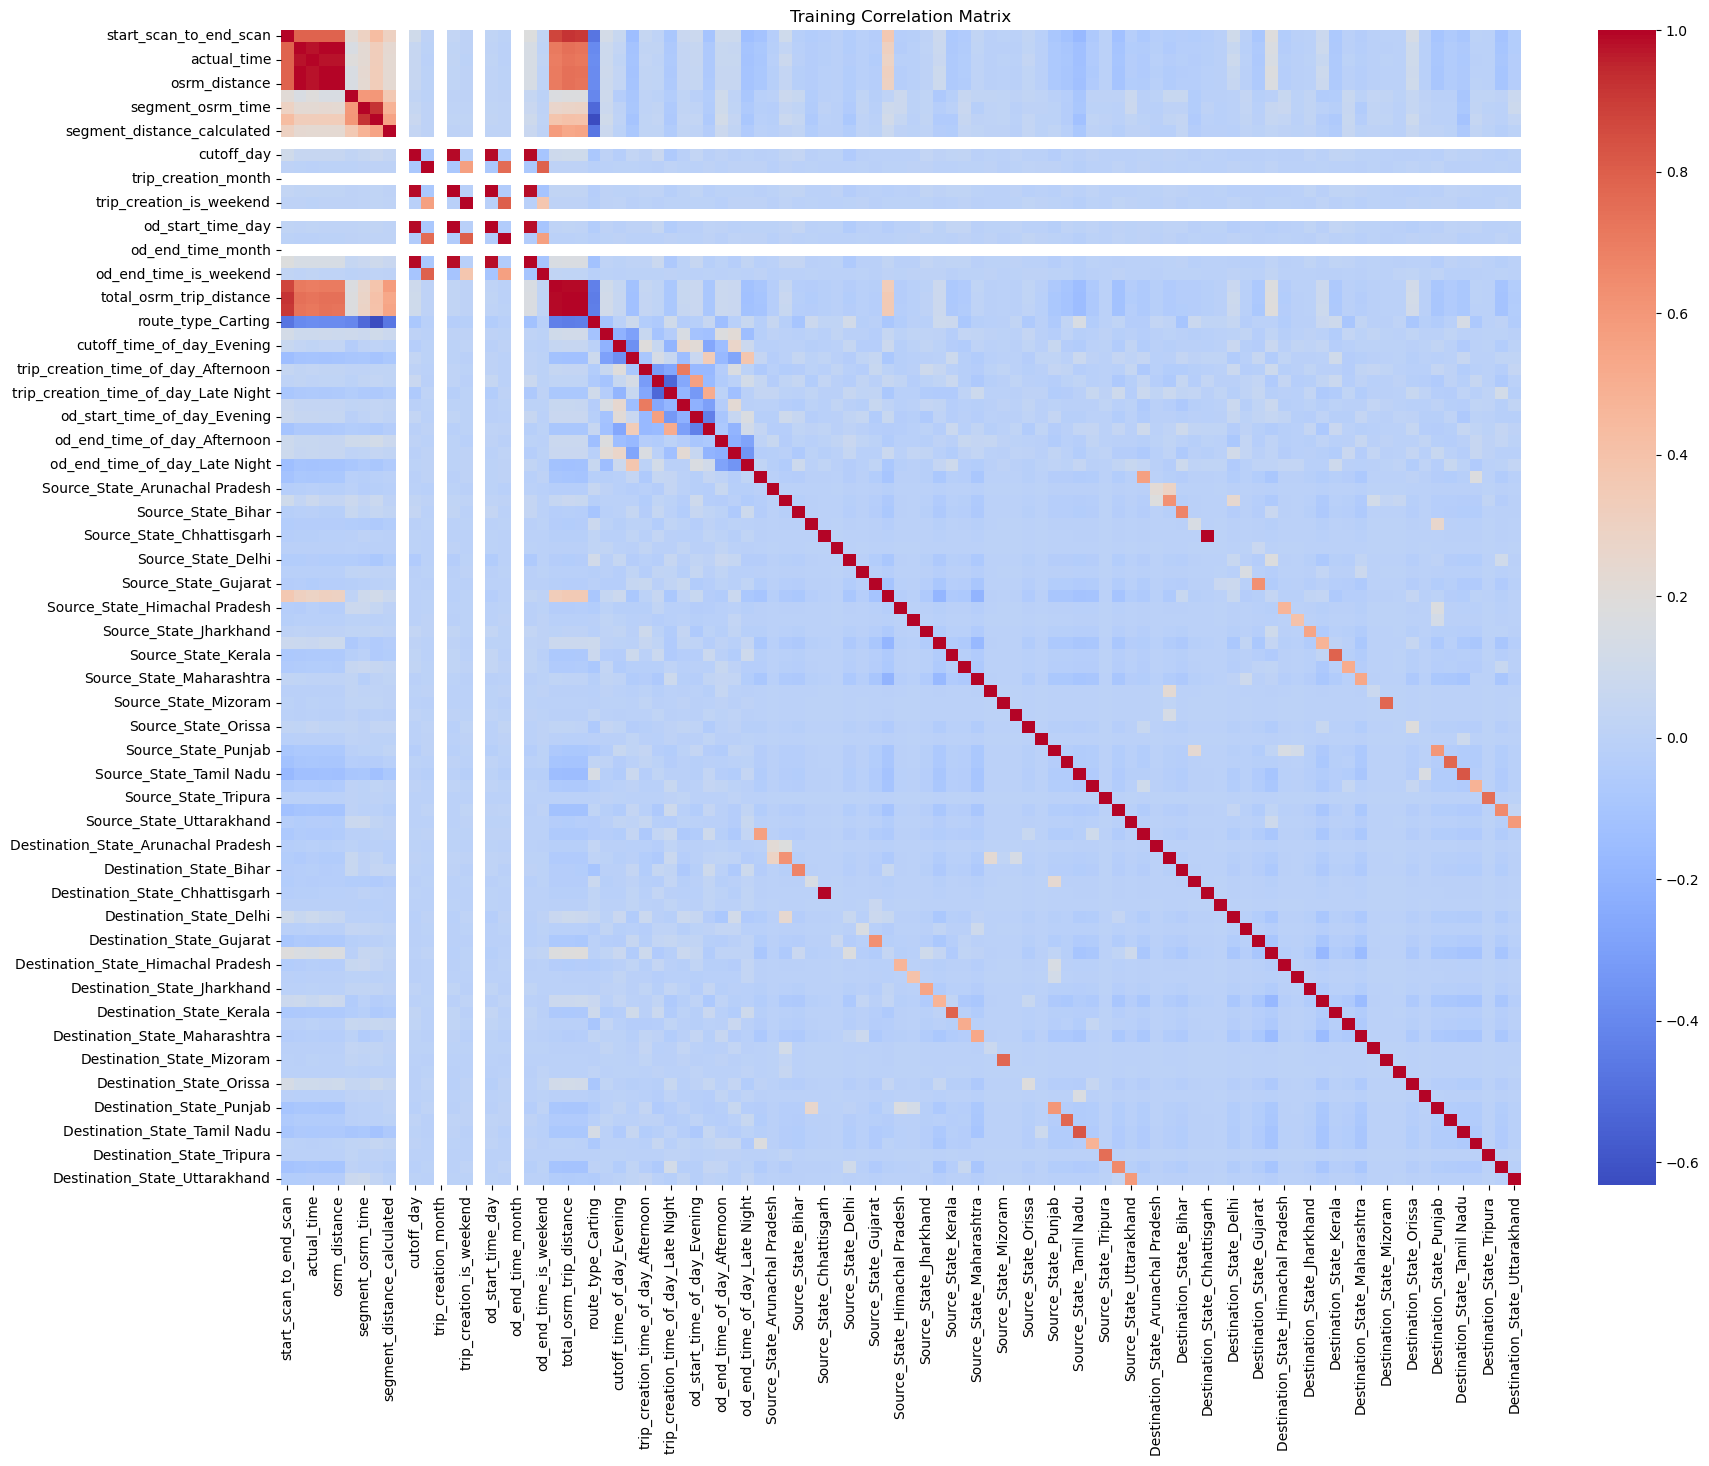

In [402]:
plt.figure(figsize=(20,15))
#cmap=sns.color_palette("coolwarm") #,as_cmap=True
sns.heatmap(standardized_training_data.corr(),cmap="coolwarm") #,annot=True,fmt='.2f'
plt.title('Training Correlation Matrix')
#plt.savefig("correlation matrix.png")
plt.show()

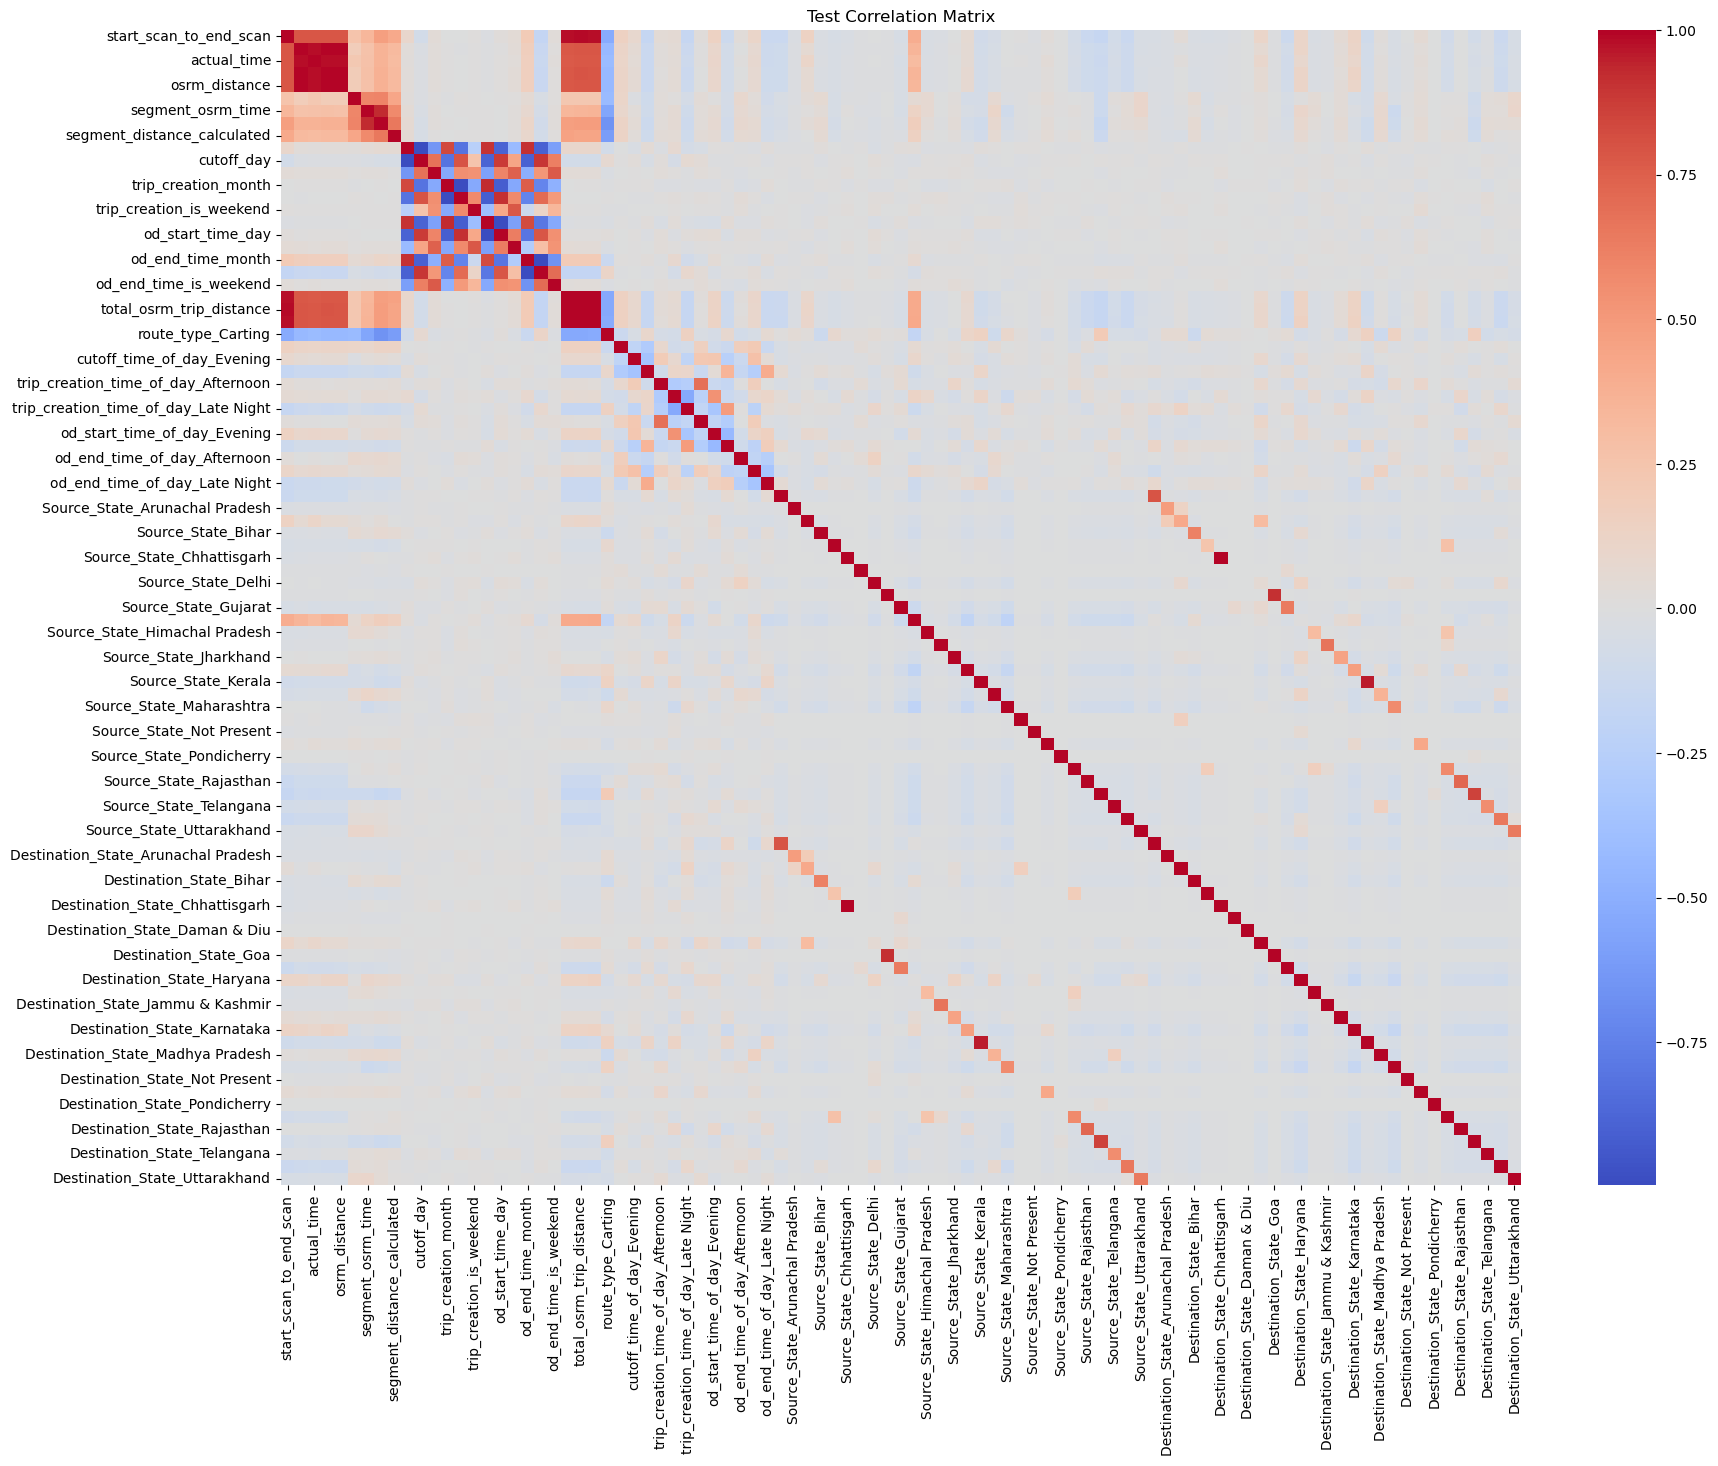

In [403]:
plt.figure(figsize=(20,15))
sns.heatmap(standardized_test_data.corr(),cmap="coolwarm") 
plt.title('Test Correlation Matrix')
#plt.savefig("correlation matrix.png")
plt.show()